# Predicting mutations from gene expression using TCGA PanCanAtlas

This notebook trains a machine learning model to predict mutations from gene expression data. We use gene expression data as an overall measurement of the "state" of the system, and we hypothesize that a machine learning model can learn to distinguish malfunctioning genes by the system's downstream response.

The model is an elastic net penalized logistic regression classifier and learns a series of weights (or gene importance scores) that together can help predict when genes are altered in a tumor. The notebook loads PanCanAtlas data, trains a machine learning model, and visualizes performance. The notebook is targeted for research purposes and can be used as a jumping-off point to generate new hypotheses. For more details about our approach see [Way _et al._ 2018](https://doi.org/10.1016/j.celrep.2018.03.046).

Please direct any questions or bug reports to [GitHub Issues](https://github.com/cognoma/machine-learning/issues).

## Notebook Structure

The notebook is organized in the following manner:

1. Specify Custom User Input from cognoma.org
2. Load and Process PanCanAtlas Data
  * Add covariate data to model (cancer-type and mutation burden)
  * Filter cancer-types and mutation status based on user input
3. Setup and Train Machine Learning Model
  * Stratify training and test set data
  * Setup pipelines for feature selection and hyperparameter tuning
  * Setup pipelines for model training and cross-validation
  * Fit the model on training set
4. Visualize Classifier Performance
  * Impact of hyperparameters
  * Optimal model Reciever Operating Characteristic (ROC) curve
5. Model Interpretation
  * Model coefficients (which genes contribute to predictions?)
  * Sample scores (which samples have unexpected high scores?)

In [1]:
import datetime
import os
import time

import numpy as np
import pandas as pd
import plotnine as gg

from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from dask_searchcv import GridSearchCV

from utils import get_model_coefficients, get_genes_coefficients, theme_cognoma
from utils import select_feature_set_columns, get_threshold_metrics

/home/gway/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline

## 1) Specify custom user input

These are the arguments that were input to [cognoma.org](http://cognoma.org)

In [3]:
# Information passed into the notebook is stored in environment variables
gene_ids = os.environ.get('gene_ids')
disease_acronyms = os.environ.get('disease_acronyms')

# Set defaults if none are provided
if not gene_ids:
    # use TP53 as the default
    gene_ids = ['7157']
else:
    gene_ids = gene_ids.split('-')

if not disease_acronyms:
    # use all of the diseases as default
    disease_acronyms = None
else:
    disease_acronyms = disease_acronyms.split('-')
    
print("Genes: {}".format(str(gene_ids)))
print("Diseases: {}".format(str(disease_acronyms)))

Genes: ['7157']
Diseases: None


## 2) Load RNAseq, mutation, and covariate PanCanAtlas data

In [4]:
path = os.path.join('download', 'expression-matrix.tsv.bz2')
expression_df = pd.read_table(path, index_col=0)

path = os.path.join('download', 'mutation-matrix.tsv.bz2')
mutation_df = pd.read_table(path, index_col=0)

path = os.path.join('download', 'covariates.tsv')
covariate_df = pd.read_table(path, index_col=0)

path = os.path.join('download', 'expression-genes.tsv')
expression_genes_df = pd.read_table(path, index_col=0)

### 2A) Process covariate data to include as variables in the model

1. Extract TCGA cancer-type indicator variables (acronyms)
2. Adjust for overall mutation burden of the tumor

In [5]:
# Select acronym_x and n_mutations_log1p covariates only
disease_cols = [col for col in covariate_df.columns if col.startswith('acronym_')]

# Filter covariate columns by disease based on input list
if disease_acronyms:
    disease_cols = [col for col in disease_cols if col.endswith(tuple(disease_acronyms))]
    
selected_cols = disease_cols + ['n_mutations_log1p']
covariate_df = covariate_df[selected_cols]

In [6]:
# Filter the rows by disease type
# subsection of columns with row-wise max
has_disease = covariate_df[disease_cols].max(axis=1) > 0
covariate_df = covariate_df[has_disease]

### 2B) Filter RNAseq and mutation data

In [7]:
expression_df = expression_df[expression_df.index.isin(covariate_df.index)]
mutation_df = mutation_df[mutation_df.index.isin(covariate_df.index)]

In [8]:
# The series holds Gene Mutation Status for each sample
# Take max of mutation status, meaning if any of the genes mutated the value should be 1
y = mutation_df[gene_ids].max(axis=1)
y.head(6)

sample_id
TCGA-02-0047-01    0
TCGA-02-0055-01    1
TCGA-02-2483-01    1
TCGA-02-2485-01    1
TCGA-02-2486-01    0
TCGA-04-1348-01    1
dtype: int64

In [9]:
print('Gene expression matrix shape: {}'.format(expression_df.shape))
print('Covariates matrix shape: {}'.format(covariate_df.shape))

Gene expression matrix shape: (7306, 20468)
Covariates matrix shape: (7306, 33)


## 3) Machine Learning

Initialize and train a machine learning algorithm to predict gene mutation status (`y`) from RNAseq gene expression data (`X`).

### 3A) Stratify training and test set data

The first step in our approach is to set 10% of the data aside for testing. The model will not be exposed to these samples and therefore provides a reasonable estimate on how the model will perform on new data.

In [10]:
# Typically, this type of split can only be done 
# for genes where the number of mutations is large enough
X = pd.concat([covariate_df, expression_df], axis='columns')
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=0)

# Here are the percentage of tumors with TP53
y.value_counts(True)

0    0.645907
1    0.354093
dtype: float64

### 3B) Feature selection

Another important consideration when developing machine learning approaches are the features used to train the model. In this case, the features are gene expression values for each gene compressed by PCA and covariate data (cancer-type and mutation burden).

First, set up [`sklearn pipelines`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) that are implemented later in the notebook.

In [11]:
# Creates the expression features by standarizing them and running PCA

# Because the expressions matrix is so large, we preprocess with PCA
# The amount of variance in the data captured by ~100 components is high
expression_features = Pipeline([
    ('select_features', FunctionTransformer(select_feature_set_columns,
        kw_args={'feature_set': 'expressions',
                 'n_covariates': covariate_df.shape[1]})),
    ('standardize', StandardScaler()),
    ('pca', PCA())
])

# Creates the covariate features by selecting and standardizing them
covariate_features = Pipeline([
    ('select_features', FunctionTransformer(select_feature_set_columns,
        kw_args={'feature_set': 'covariates',
                 'n_covariates': covariate_df.shape[1]})),
    ('standardize', StandardScaler())
])

Another important part of machine learning is to tune hyperparameters for optimal model performance. Hyperparameters are different depending on the algorithm of choice, but generally they are variables that are set in advance, prior to training. These are often chosen in non-arbitrary ways using cross-validation. 

For logistic regression, and our purposes specifically, we tune alpha regularization penalty. See [`SGDClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) for more details. Note that our elastic net penalty was set to 0 (`L2 Regression`) by default. We also use a variable number of PCA components depending on class size.

In [12]:
# Parameter Sweep for Hyperparameters
regularization_alpha_list = [10 ** x for x in range(-10, 10)]

# Chose n_components based on number of positives (or negatives, if that is less)
min_class_size = min(y.sum(), len(y) - y.sum())
if min_class_size > 500:
    n_components_list = [100]
elif min_class_size > 250:
    n_components_list = [50]
else:
    n_components_list = [30]

# Setup parameter grids to search through
param_grids = {
    'full': {
        'features__expressions__pca__n_components' : n_components_list,
        'classify__alpha': regularization_alpha_list
    },
    'expressions': {
        'features__expressions__pca__n_components' : n_components_list,
        'classify__alpha': regularization_alpha_list
    },
    'covariates': {
        'classify__alpha': regularization_alpha_list
    }
}

### 3C) Setup classifier and cross-validation pipelines

Next, initialize the classifier and 3-fold cross-validation as sklearn pipelines.

Cross validation randomly separates the training set into `n` partitions, fits the model using data from `n-1` partitions and evaluates performance on the left out partition. This process is repeated for all partitions belonging in the cross-validation test set.

In [13]:
# Initiate logistic regression object
classifier = SGDClassifier(penalty='elasticnet',
                           l1_ratio=0,
                           loss='log', 
                           class_weight='balanced',
                           random_state=0)

In [14]:
# Full model pipelines
pipeline_definitions = {
    'full': Pipeline([
        ('features', FeatureUnion([
            ('expressions', expression_features),
            ('covariates', covariate_features)
        ])),
        ('classify', classifier)
    ]),
    'expressions': Pipeline([
        ('features', FeatureUnion([('expressions', expression_features)])),
        ('classify', classifier)
    ]),
    'covariates': Pipeline([
        ('features', FeatureUnion([('covariates', covariate_features)])),
        ('classify', classifier)
    ])
}

In [15]:
# Construct cross-validated grid searches
cv_pipelines = dict()
for model, pipeline in pipeline_definitions.items():
    cv = StratifiedKFold(n_splits=3, random_state=0)
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[model],
        cv=cv,
        n_jobs=1, 
        scoring='roc_auc',
    )
    cv_pipelines[model] = grid_search

### 3E) Fit the model and determine optimal hyperparameters

Use all previously initialized variables and processed data to train machine learning models

In [16]:
# Fit the models
for model, pipeline in cv_pipelines.items():
    print('Fitting CV for model: {0}'.format(model))
    start_time = time.perf_counter()
    pipeline.fit(X=X_train, y=y_train)
    end_time = time.perf_counter()
    elapsed = datetime.timedelta(seconds=end_time - start_time)
    print('\truntime: {}'.format(elapsed))

Fitting CV for model: full


/home/gway/anaconda3/lib/python3.5/site-packages/dask/base.py:170: UserWarning: DeprecationWarning: `dask.base.Base` is deprecated. To check if an object is a dask collection use dask.base.is_dask_collection.

See http://dask.pydata.org/en/latest/custom-collections.html  for more information
  warnings.warn("DeprecationWarning: `dask.base.Base` is deprecated. "


	runtime: 0:03:23.043386
Fitting CV for model: covariates
	runtime: 0:00:25.882742
Fitting CV for model: expressions
	runtime: 0:02:59.198977


In [17]:
# Best Parameters
for model, pipeline in cv_pipelines.items():
    print('#', model)
    print(pipeline.best_params_)
    print('cv_auroc = {:.3%}'.format(pipeline.best_score_))

# full
{'features__expressions__pca__n_components': 100, 'classify__alpha': 1}
cv_auroc = 91.639%
# covariates
{'classify__alpha': 0.01}
cv_auroc = 84.097%
# expressions
{'features__expressions__pca__n_components': 100, 'classify__alpha': 1}
cv_auroc = 91.521%


## 4) Visualize Classifier Performance

### 4A) Observe performance across regularization strengths

We first visualize the performance of models across different combinations of input hyperparameters across different data types. 

In [18]:
cv_results_df = pd.DataFrame()
for model, pipeline in cv_pipelines.items():
    df = pd.concat([
        pd.DataFrame(pipeline.cv_results_),
        pd.DataFrame.from_records(pipeline.cv_results_['params'])
    ], axis='columns')
    df['feature_set'] = model
    cv_results_df = cv_results_df.append(df)
    
cv_results_summary = (cv_results_df
    .groupby(['classify__alpha', 'feature_set'])['mean_test_score']
    .max()
    .reset_index())

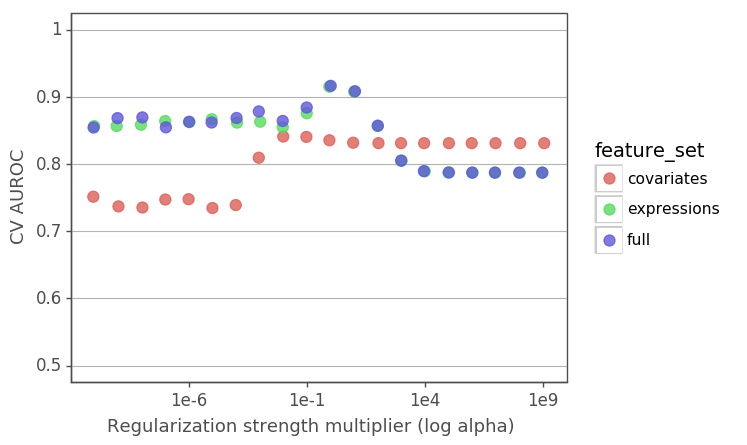

<ggplot: (8769900161456)>

In [19]:
(gg.ggplot(cv_results_summary, gg.aes(x='classify__alpha',
                                      y='mean_test_score',
                                      color='feature_set'))
 + gg.geom_jitter(size=4, alpha=0.8, height=0, width=0.05)
 + gg.scale_x_log10()
 + gg.labs(x='Regularization strength multiplier (log alpha)',
           y='CV AUROC')
 + gg.guides(fill=gg.guide_legend(title="Feature Set"))
 + gg.aes(ymin=min([0.5, cv_results_summary['mean_test_score'].min()]), ymax=1)
 + theme_cognoma()
)

### 4B) Use optimal hyperparameters to output ROC curve

Next, the model is trained with the optimal combination of hyperparameters and visualized with an ROC curve.

In [20]:
y_pred_dict = {
    model: {
        'train': pipeline.decision_function(X_train),
        'test':  pipeline.decision_function(X_test)
    } for model, pipeline in cv_pipelines.items()
}

metrics_dict = {    
    model: {
        'train': get_threshold_metrics(y_train, y_pred_dict[model]['train']),
        'test':  get_threshold_metrics(y_test, y_pred_dict[model]['test'])
    } for model in y_pred_dict.keys()
}

In [21]:
# Assemble the data for ROC curves
model_order = ['full', 'expressions', 'covariates']

auc_output = pd.DataFrame()
roc_output = pd.DataFrame()

for model in model_order:
    metrics_partition = metrics_dict[model]
    for partition, metrics in metrics_partition.items():
        auc_output = auc_output.append(pd.DataFrame({
            'partition': [partition],
            'feature_set': [model],
            'auc': metrics['auroc'].round(3)
        }))
        roc_df = metrics['roc_df']
        roc_output = roc_output.append(pd.DataFrame({
            'false_positive_rate': roc_df.fpr,
            'true_positive_rate': roc_df.tpr,
            'partition': partition,
            'feature_set': model
        }))

(gg.ggplot(roc_output, gg.aes(x='false_positive_rate',
                              y='true_positive_rate',
                              color='feature_set',
                              linetype='partition'))
 + gg.geom_line(size=1.1, alpha=0.7)
 + gg.labs(x='false positive rate', y='true positive rate')
 + theme_cognoma()
);

#### What are the AUROCs for training and testing across data types?

In [22]:
pd.pivot_table(auc_output,
               values='auc',
               index='feature_set',
               columns='partition')

partition,test,train
feature_set,,
covariates,0.853,0.844
expressions,0.911,0.914
full,0.912,0.915


## 5) Classifier Interpretation

The outputs of the model can be interpreted in various ways. For instance, the model coefficients describe the changes in gene expression that are associated with mutated or wild-type tumors for the given input gene(s).

### 5A) Determine importance scores for model features

Observe which PCA components are most predictive. Then observe which genes are most representative of the important PCA components. Investigate important coefficients for the expression only _and_ covariate plus expression models.

In [23]:
final_pipelines = {
    model: pipeline.best_estimator_
    for model, pipeline in cv_pipelines.items()
}
final_classifiers = {
    model: pipeline.named_steps['classify']
    for model, pipeline in final_pipelines.items()
}

coef_df = pd.concat([
    get_model_coefficients(classifier, model, covariate_df.columns)
    for model, classifier in final_classifiers.items()
])

In [24]:
# Signs of the coefficients by model
pd.crosstab(coef_df.feature_set, np.sign(coef_df.weight).rename('coefficient_sign'))

coefficient_sign,-1.0,1.0
feature_set,,
covariates,17,16
expressions,48,52
full,64,69


### Top coefficients for covariates model

In [25]:
coef_df.query("feature_set == 'full'").head(10)

,feature,weight,abs,feature_set
34,PCA_34,0.060877,0.060877,full
29,PCA_29,0.056681,0.056681,full
87,PCA_87,-0.053138,0.053138,full
37,PCA_37,-0.042660,0.042660,full
11,PCA_11,-0.037666,0.037666,full
24,PCA_24,0.037498,0.037498,full
2,PCA_2,-0.036474,0.036474,full
22,PCA_22,-0.035916,0.035916,full
57,PCA_57,-0.034080,0.034080,full
62,PCA_62,-0.033264,0.033264,full


### Top coefficients for individual _genes_ for full model

In [26]:
pca_for_full = (
    final_pipelines['full']
    .named_steps['features']
    .get_params()['expressions__pca']
    )

classifier_for_full = (
    final_pipelines['full']
    .named_steps['classify']
    )

gene_coefficients_for_full = get_genes_coefficients(
    pca_object=pca_for_full,
    classifier_object=classifier_for_full,
    expression_df=expression_df,
    expression_genes_df=expression_genes_df,
    num_covariates=len(covariate_df.columns)
    )

gene_coefficients_for_full.head(10)

,symbol,weight,abs,description
entrez_id,,,,
4193,MDM2,-0.007823,0.007823,MDM2 proto-oncogene
64782,AEN,-0.007198,0.007198,apoptosis enhancing nuclease
23729,SHPK,-0.006913,0.006913,sedoheptulokinase
23612,PHLDA3,-0.006636,0.006636,pleckstrin homology like domain family A member 3
81626,SHCBP1L,-0.006603,0.006603,SHC binding and spindle associated 1 like
1819,DRG2,-0.006506,0.006506,developmentally regulated GTP binding protein 2
132671,SPATA18,-0.006324,0.006324,spermatogenesis associated 18
60401,EDA2R,-0.006226,0.006226,ectodysplasin A2 receptor
1643,DDB2,-0.006150,0.006150,damage specific DNA binding protein 2


### Top coefficients for individual genes for expression model

In [27]:
pca_for_expression = (
    final_pipelines['expressions']
    .named_steps['features']
    .get_params()['expressions__pca']
    )

classifier_for_expression = (
    final_pipelines['expressions']
    .named_steps['classify']
    )

gene_coefficients_for_expression = get_genes_coefficients(
    pca_object=pca_for_expression,
    classifier_object=classifier_for_expression,
    expression_df=expression_df,
    expression_genes_df=expression_genes_df
    )

gene_coefficients_for_expression.head(10)

,symbol,weight,abs,description
entrez_id,,,,
4193,MDM2,-0.007963,0.007963,MDM2 proto-oncogene
64782,AEN,-0.007532,0.007532,apoptosis enhancing nuclease
23612,PHLDA3,-0.006923,0.006923,pleckstrin homology like domain family A member 3
81626,SHCBP1L,-0.006772,0.006772,SHC binding and spindle associated 1 like
23729,SHPK,-0.006761,0.006761,sedoheptulokinase
1819,DRG2,-0.006531,0.006531,developmentally regulated GTP binding protein 2
1643,DDB2,-0.006412,0.006412,damage specific DNA binding protein 2
132671,SPATA18,-0.006327,0.006327,spermatogenesis associated 18
60401,EDA2R,-0.006180,0.006180,ectodysplasin A2 receptor


### 5B) Investigate sample scores

We can use the classifier to score individual samples. The classifier assigns a score indicating the probability the sample has a mutation in the given input gene. We can use these scores to investigate tumors in which the mutation was not actually observed but have high scores. 

In [28]:
predict_df = pd.DataFrame()
for model, pipeline in final_pipelines.items():
    df = pd.DataFrame.from_items([
        ('feature_set', model),
        ('sample_id', X.index),
        ('test_set', X.index.isin(X_test.index).astype(int)),
        ('status', y),
        ('decision_function', pipeline.decision_function(X)),
        ('probability', pipeline.predict_proba(X)[:, 1])
    ])    
    predict_df = predict_df.append(df)

predict_df['probability_str'] = predict_df['probability'].apply('{:.1%}'.format)

In [29]:
# Top predictions amongst negatives (potential hidden responders to a targeted cancer therapy)
(predict_df
    .sort_values('decision_function', ascending=False)
    .query("status == 0 and feature_set == 'full'")
    .head(10)
)

,feature_set,sample_id,test_set,status,decision_function,probability,probability_str
sample_id,,,,,,,
TCGA-22-4591-01,full,TCGA-22-4591-01,1,0,6.410345,0.998358,99.8%
TCGA-L5-A4OH-01,full,TCGA-L5-A4OH-01,0,0,6.209589,0.997994,99.8%
TCGA-21-1081-01,full,TCGA-21-1081-01,0,0,5.699089,0.996662,99.7%
TCGA-EI-6513-01,full,TCGA-EI-6513-01,1,0,5.506395,0.995956,99.6%
TCGA-46-3765-01,full,TCGA-46-3765-01,0,0,5.357991,0.995312,99.5%
TCGA-L5-A8NR-01,full,TCGA-L5-A8NR-01,0,0,5.151024,0.994240,99.4%
TCGA-CV-7261-01,full,TCGA-CV-7261-01,0,0,4.898452,0.992597,99.3%
TCGA-20-1684-01,full,TCGA-20-1684-01,0,0,4.728480,0.991238,99.1%
TCGA-B6-A0I6-01,full,TCGA-B6-A0I6-01,0,0,4.700770,0.990994,99.1%


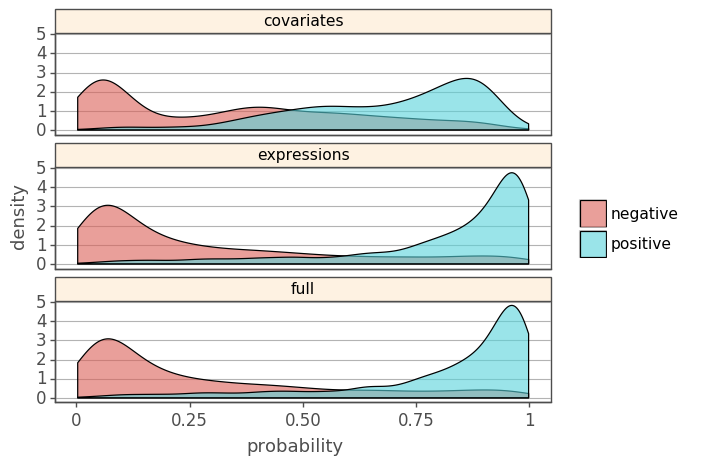

<ggplot: (8769900154344)>

In [30]:
# What is the distribution of probability assignments versus ground truth mutation status
predict_df['status_'] = predict_df['status'].map(
    lambda x: 'negative' if x == 0 else 'positive')

(gg.ggplot(predict_df, gg.aes(x='probability', 
                              fill='status_'))
 + gg.geom_density(alpha=0.6)
 + gg.facet_wrap('~feature_set', ncol=1)
 + gg.labs(x='probability', y='density')
 + gg.guides(fill=gg.guide_legend(title=""))
 + theme_cognoma())